In [1]:
#Import of all the necessary packages

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm #to show the progression of the loops
import networkx as nx #tools to construct graphs
import scipy
import os #to save the arrays we create

In [2]:
#Definition of the variables of our system

    #hyperparameters
d = 20**1#dimension of our system
alpha = 1000
time=20 #Study of the evolution of our model for time timesteps
taverage = 10**5 #number of iteration we average on for the autocorrelation matrix

    #Networkx
Nedges = 1.4 #average number of edges leaving a node

In [3]:
#Usage of the package Networkx 

    #Sampling on a Erdos-Rényi graph. We add a random weight between 0 and 1 to every edge we created. Then, we check the eigenvalues of the adjacency matrix and rescale it so that the spectral radius is smaller than 1, implying a convergence in our model.
def weightedsampling(d, Nedges, drawing="no"):
    p = Nedges / d  # Calculate edge creation probability
    print("sampling of the graph")
    
    G = nx.erdos_renyi_graph(d, p, directed=True) # Generate Erdős-Rényi graph
    
    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.uniform(0.1, 1.0) # Assign random weights to edges
    
    R = nx.to_numpy_array(G) # Convert graph to adjacency matrix

    eigenvalues = np.linalg.eigvals(R)
    R = 0.9/max(np.absolute(eigenvalues)) * R #Set the spectral radius to 0.9
    
    # Reconstruct graph if required
    if drawing == "no":
        G_reconstructed = np.identity(d)
    else:
        G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
    
    print(G)
    return R, G_reconstructed

    #Drawing of the graph. The small links do not get drawn.    
def drawing(G, pos='helper', ax=None, node_size=800, node_color='skyblue', font_size=10, font_color='black', edge_color='gray', edge_width=2.5, edge_alpha=0.8, threshold=0.02):
    spread_factor = 10 # just for the graph to look better :-)
    if pos == 'helper':  # Generate positions of the nodes in the graph if not provided
        pos = nx.spring_layout(G, k=spread_factor / np.sqrt(len(G.nodes())))
    
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_size, edgecolors='black', linewidths=1, ax=ax) # Draw nodes with customizations
    
    for u, v, d in G.edges(data=True):
        if abs(d['weight']) > threshold:  # Draw edges only if the weight is above the threshold
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_width, edge_color=edge_color, alpha=edge_alpha, arrows=True, arrowsize=15, ax=ax)
            nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): "{:.2f}".format(d['weight'])}, font_size=font_size, font_color=font_color, ax=ax)
    
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_color=font_color, ax=ax)     # Draw node labels
    
    # Adjust plot margins for better spacing
    #ax.margins(0.1, 0.1)
    
    ax.axis('off') #remove axis
    
    return pos

In [4]:
#Useful functions that we will use in the following

    #list of power of a matrix
def power(R,time,d):
    listpower = np.zeros((time,d,d))
    listpower[0] = np.identity(d)
    for i in range(1,time) :
        listpower[i] = listpower[i-1] @ R
    return(listpower)

    #list of sum of the power of the matrix squared, the i'th elem should be R**2+R**4+...+R**2i
def sumpower(R,time,d):
    sumpower = np.zeros((time,d,d))
    listpower = power(R,time,d)
    sumpower[0] = np.identity(d)
    for i in range(1,len(listpower)):
        sumpower[i] = sumpower[i-1] + listpower[i] @ np.transpose(listpower[i])
    return(sumpower,listpower)

    #discrete Lyapunov equation solution in order to compute theoretically C0
def solvediscretelyapunov(A, tol=1e-15, max_iter=1000):
    # Ensure A is a numpy array
    A = np.array(A)
    A0 = A
    X = np.zeros_like(A)
    current_sum = np.identity(len(A[0]))
    for k in range(max_iter):
        term =  A @ A.T
        A = A @ A0
        current_sum += term
        if np.linalg.norm(term, ord='fro') < tol:
            print("Number of term in the sum to compute C0 =",k)
            break
    X = current_sum
    return X

    #theoretical autocorrelation matrix of the vector autoregressive model of order 1
def theoreticalcovariance(R,time,d):
    Gamma_0 = solvediscretelyapunov(R)
    Cth= np.zeros((time,d,d))
    Cth[0] = Gamma_0
    for i in range(1,time):
        Cth[i] = R @ Cth[i-1]
    return(Cth)

    #autocorrelation time of the process
def autocorrelationtime(Cth,time):
    print("Computation of the autocorrelation time of our process")
    lambdamax = []
    for i in range(time):
        lambdamax.append(max(np.linalg.eigvals(Cth[i])))
    threshold = lambdamax[0]/math.exp(1)
    for i in range(time):
        if threshold > lambdamax[i]:
            print("Autocorrelation time of the process=", i)
            return(i)
    print("Warning : autocorrelation time bigger than the maximum time given")

    #convergence of our system to an attractor
def convergence(R, d, tconvergence):
    X0=np.random.normal(size=(d,1))
    for j in tqdm(range(10**5)):
        xi=np.random.normal(size=(d,1))
        X0 = R @ X0 + xi
    return(X0)
    
    #Computation of the serie of X 
def computationX(X,R,xi,taverage,time):
    for j in tqdm(range(taverage)):
        for t in range(0,time):
            X[j+t,:,:] = R @ X[j+t-1,:,:] + xi[j+t-1,:,:]
    return(X)
    
    #Computation of Ct by iterating the system
def computationCt(X,xi, taverage, time, autocorrtime):
    Ct = np.zeros((time,d,d))
    for j in tqdm(range(taverage)):
        for t in range(0,time):
            if j% autocorrtime == 0:
                #print("j=", j, "xi[j]@X[j]^t=",xi[j] @ np.transpose(X[j]))
                Ct[t,:,:] += X[j+t,:,:] @ np.transpose(X[j,:,:])
    return(Ct)

    #save the adjacency matrix and the measures we found
def saving(X, R, d, Nedges, taverage, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}"
    full_directory_path = os.path.join(base_directory, directory_name)
    if not os.path.exists(full_directory_path):
        os.makedirs(full_directory_path)
    Xfilename = f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy"
    Rfilename = f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    xifilename = f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy"
    Xfile_path = os.path.join(full_directory_path,Xfilename)
    Rfile_path = os.path.join(full_directory_path,Rfilename)
    xifile_path = os.path.join(full_directory_path,xifilename)
    np.savez_compressed(Xfile_path, X)
    np.savez_compressed(Rfile_path,R)
    np.savez_compressed(xifile_path,R)

    #This is a technical function, allowing us to unpack our data stored in npz format in a good way.
def load_array(file_path):
    with np.load(file_path) as data:
        array = data['arr_0']
    return array
    
    #Don't forget to put the good base directory
def loaddata(d, Nedges, taverage, base_directory=r"C:\Users\marchetta\Desktop\Stage\Results"):
    directory_name = f"matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}"
    full_directory_path = os.path.join(base_directory, directory_name)
    
    Xfile_path = os.path.join(full_directory_path, f"sample_of_matrixsize={d}_iterations={taverage}_averageconnectivity={Nedges}.npy.npz")
    Rfile_path = os.path.join(full_directory_path, f"matrix_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    xifile_path = os.path.join(full_directory_path, f"noise_of_matrixsize={d}_averageconnectivity={Nedges}.npy.npz")
    
    X = load_array(Xfile_path)
    R = load_array(Rfile_path)
    xi = load_array(xifile_path)
    return(X, R, xi)

In [5]:
#Composed function that either import the data and the graph to compute the empirical correlation matrices, or iterate the process from scratch, by first sampling a graph.
def process(d, Nedges, alpha,time, taverage, load = "no", withsave = "no", drawing = "no"):
    #Construction of our arrays and convergence to an attractor of the system.
    if load == "no":
        X = np.zeros((time + taverage - 1,d,1))
        C0=np.zeros((1,d,d))
        xi = np.random.normal(size=(time + taverage -1, d,1))
        R, G_reconstructed = weightedsampling(d, Nedges, drawing)
        print("Convergence to a fixed point")
        X[0,:] = convergence(R, d, 10**5) #this is a big value for convergence because first moment was already good but still, so that we are sure.
        print("Computation of the process")
        X = computationX(X,R,xi,taverage,time)
    else:
        print("Import of the data")
        X, R, xi = loaddata(d, Nedges, taverage)
        if drawing == "no":
            G_reconstructed = np.identity(d)
        else:
            G_reconstructed = nx.from_numpy_array(R, create_using=nx.DiGraph)
        print("Data imported")
        
    # iteration of the process and computation of Ct for each t. We average over taverage realisations.
    print("Computation of the theoretical autocorrelation matrix")
    Cth = theoreticalcovariance(R,20,d) # 20 for the max time of computation of Cth is arbitrary, it is just so that we find a good autocorrelation time in the following. Right after, we truncate it to what we need. Moreover, since we rescaled R so that it has a spectral radius of 0.9, we expect the autocorrelation time to be 9 or 10.
    autocorrtime = autocorrelationtime(Cth,20) #measures are correlated so we have to look at the characteristic time of correlation of the system, which is linked to the EV of the populatio matrix.
    Cth = Cth[:time,:,:]
    print("Computation of Ct")
    Ct = computationCt( X,xi, taverage, time, autocorrtime)
    Neff = math.floor(taverage/autocorrtime)
    print("Neff=", Neff)
    Ct=Ct/Neff
    Rt = np.zeros((time, d, d))
    for i in range(time):
        Rt[i,:,:] = alpha * Ct[i,:,:] @ np.linalg.inv(np.identity(d)+ alpha * Ct[0,:,:])
    #save the dataset    
    if withsave != "no" and load =="no": #We save in NPZ format, which is a compressed format for numpy arrays. It gives at least one less order of magnitude for the memory we have to use.
        print("Doing the save")
        saving(X, R, d, Nedges, taverage)
        print("Save successfully done")
    return(Rt, Ct, Cth ,X , autocorrtime, R, G_reconstructed, Neff)

In [6]:
# Plot of graph, and the inferred one.

def drawing_of_process(Rt, Ct, Cth, R, G_reconstructed, alpha,ax):
    print(G_reconstructed)
    Rinfered = nx.from_numpy_array(Rt[1,:,:], create_using=nx.DiGraph)
    print(Rinfered)
    count = 0
    for u, v, d in Rinfered.edges(data=True):
        if d['weight'] > 0.02:
            count += 1
    print("Number of edges plotted =",count)
    print("Drawing of the true response")
    pos = drawing(G_reconstructed, ax=ax[0])
    print("Drawing of the difference between the true response matrix and the inferred one")
    G_reconstructedar = nx.to_numpy_array(G_reconstructed)
    diff = G_reconstructedar - Rt[1,:,:]
    diffG = nx.from_numpy_array(diff, create_using=nx.DiGraph)
    pos = drawing(diffG, pos, ax=ax[1])
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
    plt.savefig(f'graph_alpha_{alpha}.png')
    plt.show()



In [7]:
#Construction of the theoretical response function using random matrix theory

    #Construction of the deterministic equivalent using the empirical correlation matrix we found above

        #self-energy of the system

def selfenergy(h, alpha):
    return alpha / (1 + h)

    #bias term
def compute_bias(Rlistpower,G, time, alpha,d):
    helperbias = np.zeros((time,d,d))
    bias = np.zeros((time,d,d))
    print("Computation of the bias term")
    for t in tqdm(range(time)):
        helperbias[t] = Rlistpower[t] @ (np.identity(d) - G)
    for t in tqdm(range(0,time)):
        for i in range(d):
            for j in range(d):
                bias[t,i,j] = helperbias[t,i,j] * helperbias[t,i,j]
    #print(resolvent(C0, alpha,d))
    return(bias)

    #variance term
def compute_variance(Rsumpower, G, time, d):
    variance = np.zeros((time,d,d))
    helper = G @ (np.identity(d)-G)
    print("Computation of the variance term")
    for t in tqdm(range(time)):
        for i in range(d):
                for j in range(d):
                    variance[t,i,j] = Rsumpower[t,i,i] * helper [j,j]
    return(variance)
                
        #fixed point iteration in order to find the renormalized coefficient alpha
    
def fixed_point_iteration(Cth, rho, alpha, initial_guess, tol, max_iter):
    eigenvalues = np.real(np.linalg.eigvals(Cth))
    listh=[]
    h_new = initial_guess
    listh.append(h_new)
    for ts in range(max_iter): # iteration of the self convergence
        h_old = copy.deepcopy(h_new)
        selfe = selfenergy(h_old, alpha) 
        h_new = 0
        for eigenvalue in eigenvalues :
            h_new += alpha/(rho * len(eigenvalues)) * eigenvalue * (1+ selfenergy(h_old,alpha) * eigenvalue)**(-1)
        if abs(h_new - h_old) < tol:
            #print("timestep =", ts)
            selfe = selfenergy(h_new, alpha) 
            #print("h final =",h_new)
            #print("selfenergy =", selfe)
            #print("ratio self-energy / alpha =", selfe/alpha)
            return selfe, h_new
        listh.append(h_new)
    selfe = selfenergy(h_new, alpha)
    print("Warning: Maximum number of iterations reached.")
    print("h final =",h_new)
    print("selfenergy =", selfe)
    print("Ratio self-energy / alpha =", selfe/alpha)
    return selfe, h_new
        
    #resolvent-like quantity
    
def resolvent(C,alpha,d) :
    return(np.linalg.inv(np.identity(d) + alpha * C))

        #theoretical formula
def RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d, sigma = 1, initial_guess = alpha/10000, tol=1e-15, max_iter=10000):
    print("Computation of the theoretical covariance")
    Rsumpower, Rlistpower = sumpower(R,time,d)
    helperbias = np.zeros((time,d,d))
    bias = np.zeros((time,d,d))
    variance = np.zeros((time,d,d))
    print("Fixed point convergence")
    selfe, _ = fixed_point_iteration(Cth[0], rho, alpha, initial_guess, tol, max_iter)
    print("Computation of bias and variance term")
    print('renormalized alpha=',selfe)
    G = resolvent(Cth[0], selfe,d)
    bias = compute_bias(Rlistpower,G, time, alpha,d)
    variance = compute_variance(Rsumpower, G, time, d)
    variance = alpha * sigma / Neff * variance 
    RTrmt = bias + variance
    return (RTrmt, bias, variance)

#this formula is the one without going to the random matrix formalism.
def RMTempiricalresponseBIS(Ct, R, alpha, time, Neff, d, sigma = 1):
    print("Computation of the theoretical covariance")
    Rsumpower, Rlistpower = sumpower(R,time,d)
    helperbias = np.zeros((time,d,d))
    bias = np.zeros((time,d,d))
    variance = np.zeros((time,d,d))
    print("Computation of bias and variance term")
    G = resolvent(Ct[0], alpha,d)
    bias = compute_bias(Rlistpower,G, time, alpha,d)
    variance = compute_variance(Rsumpower, G, time, d)
    variance = alpha * sigma / Neff * variance 
    RTrmt = bias + variance
    return (RTrmt, bias, variance)


In [8]:
def computation_responses(d,Nedges,alpha,time,taverage, load = "no", withsave = "no", drawing = "no"):
    RTcorr, Ct, Cth,X, autocorrtime, R, G_reconstructed, Neff = process(d, Nedges, alpha,time, taverage, load, withsave, drawing)
    if drawing !="no" :
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        drawing_of_process(RTcorr, Ct, Cth, R, G_reconstructed, alpha, ax=axes)
    rho = Neff/d #rho is smaller than the true one since we took measures only after a certain autocorrelation time.
    RTrmt, bias, variance= RMTempiricalresponse(Cth, R, rho, alpha, time, Neff, d)
    return(RTcorr, Ct, Cth, R, G_reconstructed, Neff, RTrmt, bias, variance)

In [9]:
#Plot of both the response functions inferred, one with the theory and one with the covariance matrices. We choose the indices randomly but you can precise them.

def plotcomparisons(RTrmt, bias, variance, RTcorr, d, i = "random", j = "random"):
                           
    if i == "random":
        i = np.random.randint(0, d)
    if j == "random":
        j = np.random.randint(0, d)
    line2, = plt.plot(RTrmt[:, i, j], linestyle ="--", marker='D',label="Response using the tools of RMT")
    line3, = plt.plot(bias[:,i,j],linestyle ="--", color = 'green', alpha = 0.5, label = "Contribution of the bias")
    line4, = plt.plot(variance[:,i,j], color = 'red', linestyle ="--", alpha = 0.5, label = "Contribution of the variance")
    line1, = plt.plot(RTcorr[:, i, j], linestyle ="--", marker ="X", label="Response using the correlation matrices")
    plt.legend(handles=[line1, line2, line3, line4])
    plt.xticks(np.arange(1, len(RTrmt[:,i,j]), 2))
    plt.xlabel("time t")
    plt.ylabel(f'$R^2_{{{j},{i}}}(t)$')
    #plt.title(f"Response function inferred by two different methods \n for alpha = {alpha}.")

sampling of the graph
DiGraph with 20 nodes and 21 edges
Convergence to a fixed point


  0%|          | 0/100000 [00:00<?, ?it/s]

Computation of the process


  0%|          | 0/100000 [00:00<?, ?it/s]

Computation of the theoretical autocorrelation matrix
Number of term in the sum to compute C0 = 179
Computation of the autocorrelation time of our process
Autocorrelation time of the process= 1
Computation of Ct


  0%|          | 0/100000 [00:00<?, ?it/s]

Neff= 100000
Doing the save
Save successfully done
DiGraph with 20 nodes and 21 edges
DiGraph with 20 nodes and 400 edges
Number of edges plotted = 21
Drawing of the true response
Drawing of the difference between the true response matrix and the inferred one


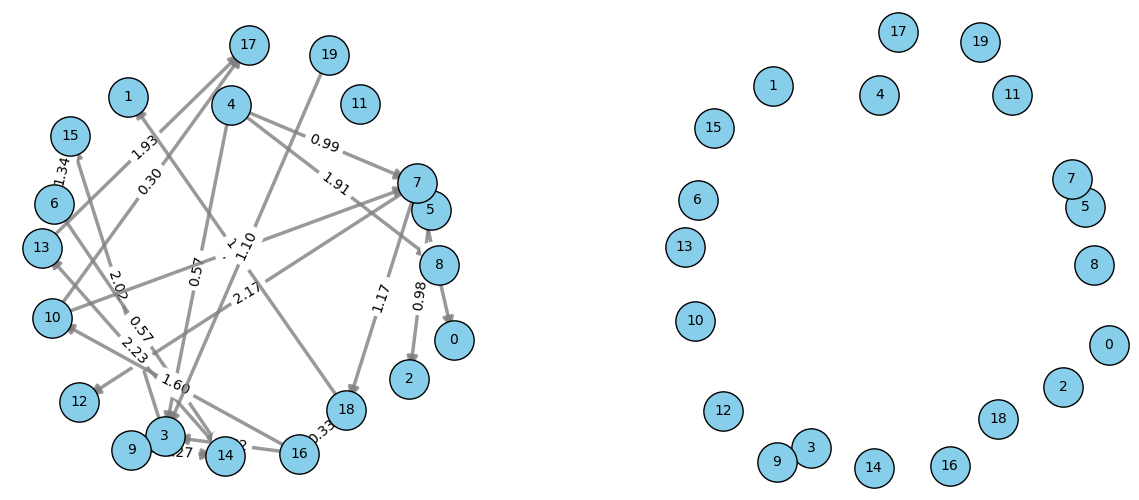

Computation of the theoretical covariance
Fixed point convergence
Computation of bias and variance term
renormalized alpha= 999.8001084631295
Computation of the bias term


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Computation of the variance term


  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
RTcorr, Ct, Cth, R, G_reconstructed, Neff, RTrmt, bias, variance = computation_responses(d, Nedges, alpha, time, taverage, load ="no", withsave="yes", drawing = "yes")

#If you get an error message, it may means that the sampled graph do not have good characteristics (eigenvalues,...)

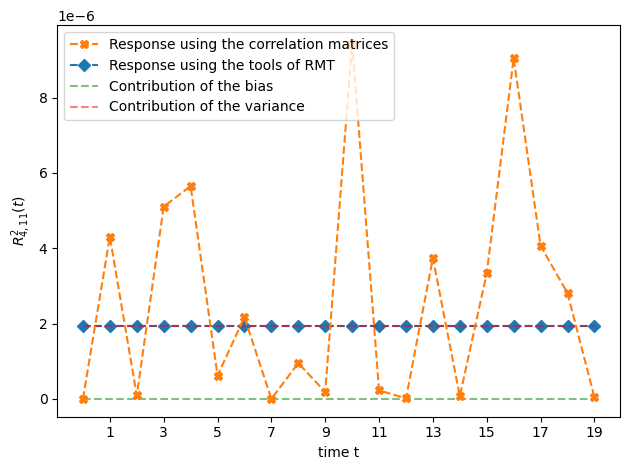

In [17]:
i = 9
j = 6
i = np.random.randint(0, d)
j = np.random.randint(0, d)

plotcomparisons(RTrmt, bias, variance, RTcorr**2, d, i, j)
plt.tight_layout()
#plt.savefig(f'link from {j} to {i} with D={d}, N={taverage}, average connectivity ={Nedges}')
plt.show()

In [12]:
#To check, one can find the true edges present on the graph and then use the label to check in the plot for the response found in the two different ways.
def checkforedges(R):
    listedges = [[],[]]
    for i in range(len(R[0])):
        for j in range(len(R[0])):
            if R[i,j] != 0:
                if j == 100 :
                    print("i",i, R[i,j])
                if i == 165 :
                    print(j, R[i,j])
                listedges[0].append(i)
                listedges[1].append(j)
    return(listedges)
a = checkforedges(R)
index = 0
print(a[0][index], a[1][index])

3 15


In [13]:
#Function in order to plot the renormalized alpha as a function of rho

def plotrenormalizedalpha(Cth, Nmeasures, alpha): 
    selfenergy = np.zeros((Nmeasures,1))
    ratio = np.zeros((Nmeasures,1))
    h_new = np.zeros((Nmeasures,1))
    rho = np.linspace(10**-1, 10**1, Nmeasures)    
    for i in range(0,Nmeasures):
        selfenergy[i], h_new[i] = fixed_point_iteration(Cth[0],rho[i], alpha, initial_guess = alpha/10000, tol=1e-15, max_iter=10000)
    ratio = selfenergy/alpha
    plt.scatter(rho,ratio[:,0], marker ="X")
    plt.xlabel('rho')
    plt.ylabel('ratio selfenergy/alpha')
    plt.xscale('log')
    plt.show()
        
#plotrenormalizedalpha(Cth,10000,alpha)

In [14]:
#Different plotting schemes :

# construction of plots than can be put in an article
def response_image(RTrmt,bias, variance, RTcorr, d, taverage, Nedges, i, j)
    plotcomparisons(RTrmt, bias, variance, RTcorr**2, d, i, j)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'link from {j} to {i} with D={d}, N={taverage}, average connectivity ={Nedges}.pdf', format = 'pdf')
    plt.show()
    
#response_image(RTrmt, bias, variance, RTcorr, d, taverage, Nedges, i, j)

# construction of plots of the EV of the correlation matrix
def diagonalization(Ct):
    eigen = np.linalg.eigvals(Ct)
    plt.hist(eigen, bins=300, density = "true", edgecolor='black', alpha = 0.5, label = "empirical histogram of eigenvalues")
    plt.xlabel('Eigenvalue')

#Construction of the MP plot   
def marchenko_pastur_distribution(rho, num_points=1000):
    # Calculate the support of the distribution
    lambda_min = (1 - np.sqrt(rho))**2
    lambda_max = (1 + np.sqrt(rho))**2

    # Generate the lambda values
    lambdas = np.linspace(lambda_min, lambda_max, num_points)

    # Calculate the Marchenko-Pastur density
    density = (1 / (2 * np.pi * rho * lambdas)) * np.sqrt((lambda_max - lambdas) * (lambdas - lambda_min))
    density = np.nan_to_num(density)  # Handle any NaNs resulting from sqrt of negative numbers
    plt.plot(lambdas, density, label ="Marchenko-Pastur distribution", color ='r')
    # Plot the distribution
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    plt.xlim(0,10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.savefig('plot of eigenvalues for d = 1000.pdf', format = 'pdf')
rho = Neff/d

#diagonalization(Ct[0])
#marchenko_pastur_distribution(1/rho)
    

SyntaxError: expected ':' (3993959643.py, line 4)